In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
import sklearn
from math import sqrt
import seaborn as sns
import warnings
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore")


# Load Data

In [2]:
df = pd.read_csv("winemag-data-130k-v2.csv")

In [3]:
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


# Visualization 1

Text(0, 0.5, 'Average Price')

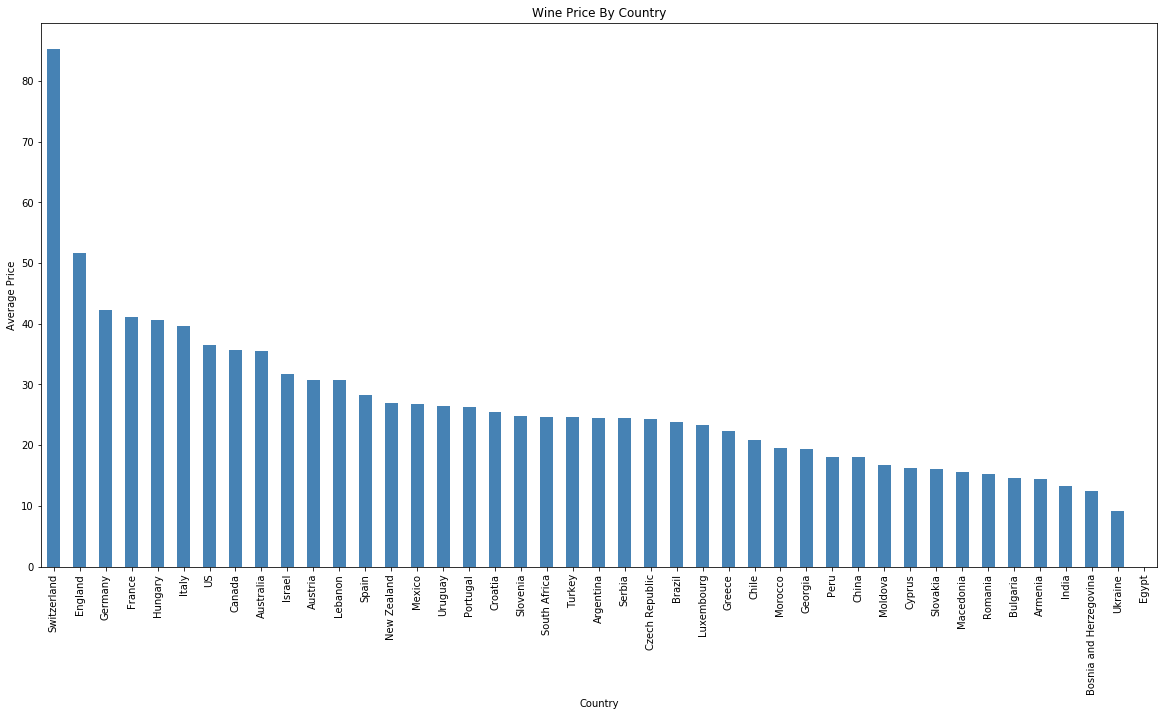

In [4]:
plt.figure(figsize=(20,10))

# group by year and calculate mean of open price
df.groupby(pd.Grouper(key='country')).mean()['price'].sort_values(ascending=False).plot.bar(color='steelblue')

# show labels 
plt.title('Wine Price By Country')
plt.xlabel('Country')
plt.ylabel('Average Price')

The most important attributes should be encoded with the most effective channels in order to be most noticeable and the most effective is aligned spatial position (VAD page 101) so I sort the mean of wine from high to low. The key attribute, country, separates the marks along the horizontal spatial axis. The value attribute, average price, expresses the value with aligned vertical spatial position and line marks.  
The bar plot shows that Switzerland has highest wine price than other countries.

# Visualization 2

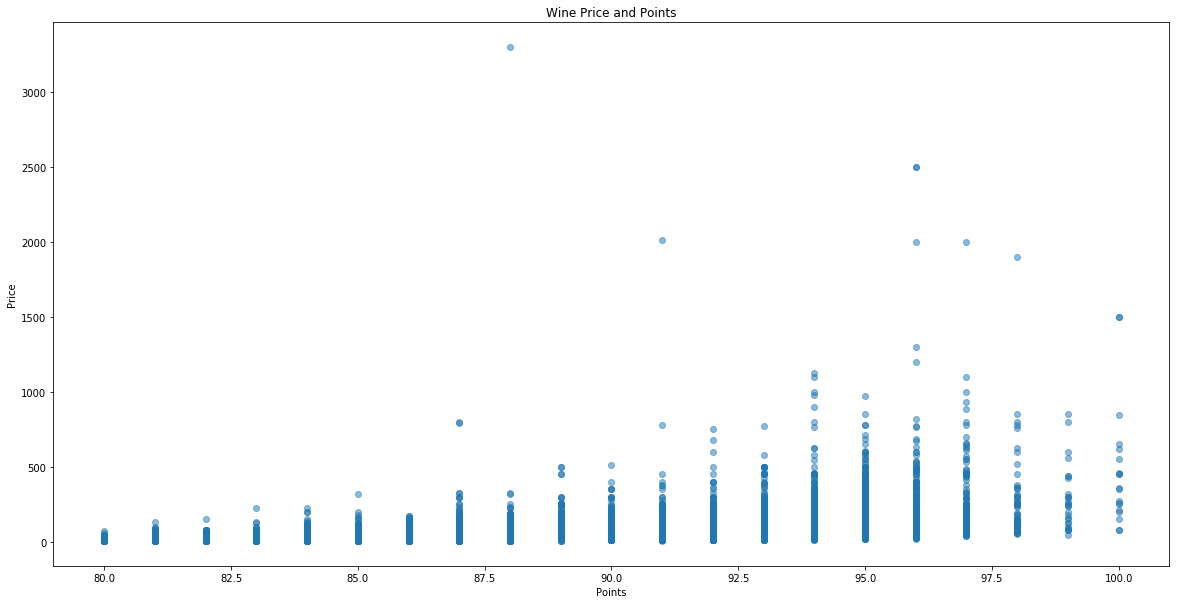

In [5]:
# scatter plot point and price
plt.figure(figsize=(20,10))
plt.scatter(df['points'], df['price'],alpha=0.5)
plt.title('Wine Price and Points')
plt.xlabel('Points')
plt.ylabel('Price')
plt.show()

I applied the scatter plot to show the relationship between
the price and point. The scatter plot expresses values with horizontal and vertical
spatial position and point marks and fulfill the task of finding trends, outliers, and
locate cluster(VAD page 148).
From the plot, we can tell that price is tend to be higher when points get higher.

# Preprocessing


In [6]:
df.shape

(129971, 14)

In [7]:
df.describe(include='all').loc['unique', :]

Unnamed: 0                  NaN
country                      43
description              119955
designation               37979
points                      NaN
price                       NaN
province                    425
region_1                   1229
region_2                     17
taster_name                  19
taster_twitter_handle        15
title                    118840
variety                     707
winery                    16757
Name: unique, dtype: object

In [8]:
df.isnull().sum() 

Unnamed: 0                   0
country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

In [9]:
# Clean data 
df = df.dropna()
df = df.drop(columns = ['Unnamed: 0','region_2', 'designation', "region_1", 
                        "taster_name", "taster_twitter_handle", 'title', "winery"])

Drop NAs and drop Unnamed as it's just index column.  
Drop taster_twitter_handle is one-to-one with taster_name. Drop taster_name and region_1 becase they have too many NAs.  
Drop designation, winery, title becasue they have too many distinct values. 

In [10]:
# Take sample to shortern the runtime
df1 = df.sample(n=1000)

## Remove stop words

In [11]:
# Remove stop word
stop_words = stopwords.words('english')
df1['description'] =  df1['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


## Split the dataset randomly into train/test (80/20)


In [12]:
train, test = train_test_split(df1, test_size=0.2, random_state = 0)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [13]:
# One hot encode for categorical features
train = pd.get_dummies(train, columns=['country', "province", "variety"])
test = pd.get_dummies(test, columns=['country', "province", "variety"])

In [14]:
# Instantiate encoder/scaler
scaler = StandardScaler()
train[['price','points']] = scaler.fit_transform(train[['price','points']])
test[['price','points']] = scaler.transform(test[['price','points']])

In [15]:
# TFIDF
vectorizer = TfidfVectorizer(sublinear_tf = True)
train_d = vectorizer.fit_transform(train['description'])
test_d = vectorizer.transform(test['description'])

# Drop the description column
train = train.drop(columns = ["description"])
test = test.drop(columns = ["description"])

train_x= train.drop(columns = ['points'])
train_validate = list(train['points'])
test_x = test.drop(columns = ['points'])
test_validate = list(test['points'])

# LDA
lda = LDA()
train_d = lda.fit_transform(train_d)
test_d = lda.transform(test_d)

# concat
train_1 = pd.DataFrame({str(i+1): train_d[:,i] for i in range(train_d.shape[1])})
test_1 = pd.DataFrame({str(i+1): test_d[:,i] for i in range(test_d.shape[1])})
train_x = pd.concat([train_x, train_1], axis = 1)
test_x = pd.concat([test_x, test_1], axis = 1)
feature_names = np.array(train_x.columns)
train_x = train_x.values
test_x = test_x.values

# Modeling
## Set initial values

In [16]:
alphas = 10**np.linspace(10,-2,100)*0.5

ridge_rmse = lasso_rmse =  []
ridge_min_rmse =  lasso_min_rmse = 100
ridge_parameter = lasso_parameter = 0

df_scores = pd.DataFrame(columns=['model', 'score'])
df_scores_lasso = pd.DataFrame(columns=['model', 'score'])
df_scores_gbr = pd.DataFrame(columns=['model', 'score'])

# Ridge Regression

In [17]:
for a in alphas:
    ridge = Ridge()
    ridge.set_params(alpha = a)
    ridge_score = cross_validate(ridge, train_x, train_validate, cv=10, 
                                 scoring=('neg_mean_absolute_error'))['test_score']
    ridge_rmse.append(np.sqrt(np.abs(ridge_score)))  
    if np.mean(ridge_rmse[-1]) < ridge_min_rmse:
        ridge_min_rmse = np.mean(ridge_rmse[-1])
        ridge_parameter = a
        df_scores['model'] = 'Ridge'
        df_scores['score'] = ridge_rmse[-1]
        
print("alpha* = %.2f,"%(ridge_parameter), "RMSE= %.4f."%(ridge_min_rmse))

alpha* = 37.82, RMSE= 0.8654.


In [50]:
# Fit with the most optimal
ridge_op = Ridge(alpha=37.82)
ridge_op.fit(test_x, test_validate)
print(np.sqrt(mean_squared_error(ridge_op.predict(test_x),test_validate)))

0.7282440740368838


# Lasso Regression


In [39]:
for a in alphas:
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso_score = cross_validate(lasso, train_x, train_validate, cv=10, 
                                 scoring=('neg_mean_absolute_error'))['test_score']
    lasso_rmse.append(np.sqrt(np.abs(lasso_score)))  
    if np.mean(lasso_rmse[-1]) <lasso_min_rmse:
        lasso_min_rmse = np.mean(lasso_rmse[-1])
        lasso_parameter = a
        df_scores_lasso['model'] = 'Lasso'
        df_scores_lasso['score'] = lasso_rmse[-1]

        
print("alpha* = %.2f,"%(lasso_parameter), "RMSE= %.4f."%( lasso_min_rmse))

alpha* = 0.19, RMSE= 0.8699.


In [49]:
# Fit with the most optimal
lasso_op = Lasso(alpha=0.19)
lasso_op.fit(test_x, test_validate)
print(np.sqrt(mean_squared_error(lasso_op.predict(test_x),test_validate)))

0.5914897276606116


# Gradident Boosting Regression

In [42]:
num = np.linspace(10, 100, 10)
max_depth = np.linspace(5, 50, 10)
gbr_rmse = []
gbr_min_rmse = 100
gbr_paramter = 0
score_gbr = 100

for n in num:
    for depth in max_depth:
        GBR = GradientBoostingRegressor(n_estimators=int(n), max_depth = int(depth))
        gbr_scores = cross_validate(GBR, train_x, train_validate, cv=10, scoring=('neg_mean_absolute_error'))['test_score']
        gbr_rmse.append(np.sqrt(np.abs(gbr_scores)))   
        if np.mean(gbr_rmse[-1]) < gbr_min_rmse:
            gbr_min_rmse = np.mean(gbr_rmse[-1])
            gbr_paramter = [n, depth]
            df_scores_gbr['model'] = 'Gradient Boosting'
            df_scores_gbr['score'] = gbr_rmse[-1]
            
print("n_estimator* = %.2f,"%(gbr_paramter[0]), "depth* = %.2f,"%(gbr_paramter[1]), "RMSE = %.4f."%(gbr_min_rmse))

n_estimator* = 10.00, depth* = 50.00, RMSE = 0.8745.


In [48]:
# Fit with the most optimal
gbr_op = GradientBoostingRegressor(n_estimators=10, max_depth = 50)
gbr_op.fit(test_x, test_validate)
print(np.sqrt(mean_squared_error(gbr_op.predict(test_x),test_validate)))

0.3231450891865535


# Visualization 3

Text(0, 0.5, 'RMSE')

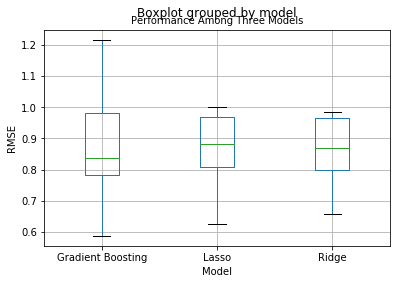

In [46]:
df_scores = df_scores.append(df_scores_lasso).append(df_scores_gbr)

df_scores.boxplot(by='model',  column=['score'],   grid=True)

plt.title("Performance Among Three Models", fontsize=10)
plt.xlabel('Model')
plt.ylabel('RMSE')


The boxplot is an idiom presenting summary statistics for the distribution of a quantitative attribute, using five derived values. Original attribute expressing derivedattribute values using vertical spatial position, with1D list alignment of glyphs into separated with horizontal spatial position (VAD page 309).   
Graident Boosting Regression has lowest mean RMSE value and it has best performance

Text(0, 0.5, 'Percentage')

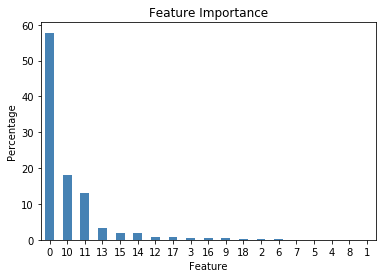

In [75]:
importance = gbr_op.feature_importances_
importance = 100 *importance / importance.sum()
importance = pd.DataFrame(importance)
importance[0].sort_values(ascending=False).plot.bar(color='steelblue',rot=0)
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Percentage")

The most important attributes should be encoded with the most effective channels in order to be most noticeable and the most effective is aligned spatial position (VAD page 101) so I sort the percentage of a feature capture among all other features. The key attribute, feature, separates the marks along the horizontal spatial axis. The value attribute, percentage, expresses the value with aligned vertical spatial position and line marks (VAD page 150). Latent varialbes are the most importance features in prediction.

